# Shifts and Lags using covariates and model averaging (stacking)

## TODO

- Define set of priors (for reproducibility)
- Try autocorrelation model and check how fast it is
- Create dashboard

In [119]:
library(here)
library(haven)
library(sdazar)
library(ggplot2)
library(stringr)
library(brms)
options(mc.cores = parallel::detectCores()-2)
library(imputeTS)
# library(stringr)
# library(ggridges)
# library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
library(texreg)

Version:  1.36.23
Date:     2017-03-03
Author:   Philip Leifeld (University of Glasgow)

Please cite the JSS article in your publications -- see citation("texreg").


In [2]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

# Only male-female average and records since 1900

In [3]:
covariates = names(df)[10:28]

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
# (nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


### Define dataset

In [4]:
test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

In [5]:
# year recode based on the criteria proposed by Alberto
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']
# # test[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

# transform variable: weibull


test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
test[, max_le := max(Ex+1.05), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]


get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

In [6]:
head(test)

ctry,year,gdp_pc,urban,lit,Ex,water,sewage,elec,us_aid,tfr,gyear,y,wy,max_le,ctry_year
Argentina,1900,2875.352,NA,51,36.25867,NA,NA,NA,NA,NA,1950,0.4762391,-0.4358419,76.13545,Argentina.1950
Argentina,1901,2880.387,NA,NA,36.63120,NA,NA,NA,NA,NA,1950,0.4811320,-0.4214333,76.13545,Argentina.1950
Argentina,1902,2716.507,NA,NA,37.00985,NA,NA,NA,NA,NA,1950,0.4861054,-0.4068604,76.13545,Argentina.1950
Argentina,1903,2992.315,NA,NA,37.39479,NA,NA,NA,NA,NA,1950,0.4911614,-0.3921179,76.13545,Argentina.1950
Argentina,1904,3191.040,NA,NA,37.82295,NA,NA,NA,NA,NA,1950,0.4967851,-0.3758025,76.13545,Argentina.1950
Argentina,1905,3478.617,NA,NA,38.48985,NA,NA,NA,NA,NA,1950,0.5055445,-0.3505536,76.13545,Argentina.1950


In [7]:
# number of countries
length(unique(test$ctry))

[1] 19

# 1900+ model using gdp, lit, urban imputed (Interpolation)

In [8]:
library(imputeTS)

test = data.table(test)
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

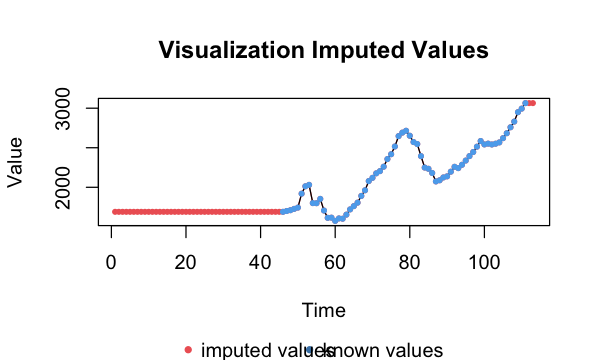

In [9]:
country = 'Bolivia'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

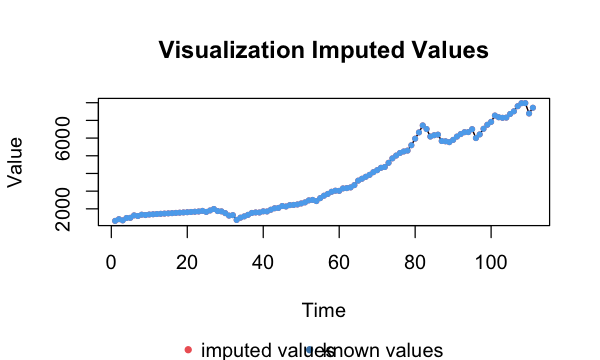

In [17]:
country = 'Mexico'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

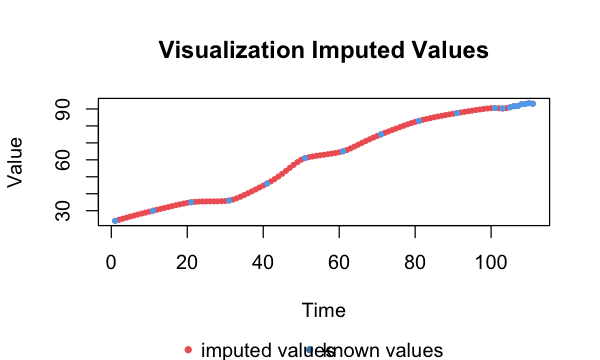

In [14]:
country = 'Mexico'
variable = 'lit'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

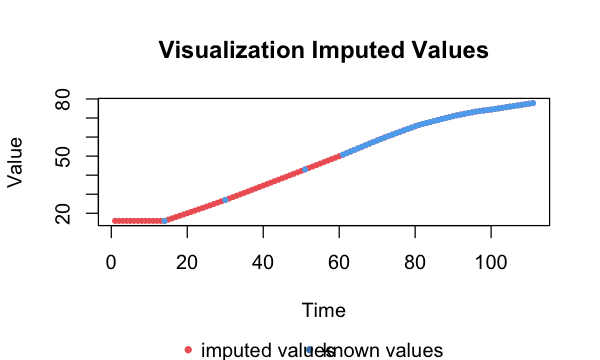

In [13]:
country = 'Mexico'
variable = 'urban'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

## Bayesian models using the interpolation method

In [18]:
test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]

In [19]:
# lag variables and fitering
setorder(test, ctry, year)

In [20]:
# test[, lag_igdp_log := shift(igdp_log), by=ctry]
# test[, lag_iurban_log := shift(iurban_log), by=ctry]
# test[, lag_ilit_log := shift(ilit_log), by=ctry]
test[, zyear := scale(year, center=TRUE, scale=TRUE)]

# Models 

Important notes: 

- Random intercept by country and year
- Random GDP coefficient by country and year
- All the other covariates are fixed (unique coefficient or beta)
- No interactions between variables

In [19]:
m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2)

loo1.1 = loo(m1.1, reloo=TRUE)

m1.2 = brm(formula = wy ~ 1 + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo1.2 = loo(m1.2, reloo=TRUE)

m1.3 = brm(formula = wy ~ 1 + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2)

loo1.3 = loo(m1.3, reloo=TRUE)

m1.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo1.4 = loo(m1.4, reloo=TRUE)

# stacking
loo_list_1 = list(loo1.1, loo1.2, loo1.3, loo1.4)
weights_models_1 = as.vector(loo_model_weights(loo_list_1))
print(weights_models_1)

Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 368)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1375)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1632)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1420)
Start sampling


[1] 1.410036e-02 2.349323e-07 1.661370e-02 9.692857e-01


# Function to get shifts using all models and weights

In [25]:
estimate_shift = function(models=NULL, # list
                          ps=NULL, # list, posterior samples
                          data=NULL, # data.table 
                          country=NULL, # string
                          weights= NULL, # vector, lenght = number of models
                          cfyear=NULL, # numeric 
                          segment=NULL, # string representing period, valid values 1950, 1950-1969, 1970-1989, 1990
                          predicted_values=FALSE # boolean
                         )  { 
  
    differences = list()
    model_pred = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989', '2010' = '1990')

    
    # equal weights (average) if they are not specified
    if (is.null(weights)) { weights = rep(1/length(models), length(models)) }
    
    # loop through models
    for (i in seq_along(models)) {
        
        
        if (is.null(ps)) {  s = data.table(posterior_samples(models[[i]])) } 
        else {  s = data.table(ps[[i]]) }
   
        # counterfactual using previous coefficients and intercepts (random effects)   
        if (is.null(segment)) { igyear = model_pred[as.character(cfyear)] }
        else { igyear = segment }
        
            
        if (!igyear %in% as.vector(unlist(model_pred))) { stop('Segment (period) is not valid!') }  
        
        colnames = names(s)
        betas = grep('^b_', colnames, value=TRUE)
        random = str_subset(colnames, paste0('^r_.+\\[', country, '.', igyear, ','))
        coef = c(betas, random)
#         print(coef)

        variables = c('ctry', 'year', sub('b_', '', betas))
        variables = variables[variables != 'Intercept']
        covariates = sub('b_', '', betas)
        
        data[, Intercept := 1]
        dt  = data[ctry==country & year==cfyear, ..covariates]
#         print(head(dt))
                             
        max_le = unique(test[ctry==country & year==cfyear, max_le])
        ex_obs = unique(test[ctry==country & year==cfyear, Ex])
    
#     print(ex_obs)
    
        st = s[, ..coef] # select coefficients
#         print(coef)
#         print('counterfactual')
#         print(head(st))
        for (h in seq_along(covariates)) {
            st[, covariates[h] := rowSums(.SD), .SDcols = grep(covariates[h], names(st), value=TRUE)]
        }

        mt = as.matrix(st[, ..covariates])
        
#         print(head(mt))
        
        cf = mt %*% as.vector(as.matrix(dt)) # counterfactual
        cf = unlist(sapply(cf, function(x) get_orig_values_weibull(x, max_value=max_le)))

#         print(head(cf))
                       
        if (predicted_values) { # using predicted values (all random effects) instead of observed Ex
            
            pigyear =  data[ctry==country & year == cfyear, gyear]
#             print(igyear)
#               print('prediction')
            prandom = str_subset(colnames, paste0('^r_.+\\[', country, '.', pigyear, ','))
            pcoef = c(betas, prandom)
#             print(coef)
            pt = s[, ..pcoef]
#             print(head(pt))
#             print(covariates)
            for (h in seq_along(covariates)) {
                pt[, covariates[h] := rowSums(.SD), .SDcols = grep(covariates[h], names(pt), value=TRUE)]
            }
            
#             print(dt)
            mpt = as.matrix(pt[, ..covariates])
#             print(head(mpt))
            ex_pred = mpt %*% as.vector(as.matrix(dt))
            ex_pred = unlist(sapply(ex_pred, function(x) get_orig_values_weibull(x, max_value=max_le)))
#             print(summary(ex_pred))
            ex_pred = mean(ex_pred)
                                            
#             print(length(ex_pred))
#             print(length(cf))
#             print(summary(cf))
#             print(paste0('ex pred: ', ex_pred))
#             print(paste0('ex obs: ', ex_obs))
#             print(paste0('cf :', mean(cf)))
                              
            differences[[i]]  = ex_pred - cf
                                    
        } else { differences[[i]] = ex_obs - cf } # using observed Ex values       
#             print(head(differences[[i]]))
      }  
                           
    # combine values (differences) using weights
    return( as.vector(as.matrix(setDT(differences)) %*% weights) ) # return a vector
}

In [26]:
models_1 = list(m1.1, m1.2, m1.3, m1.4)
ps_1 = list(posterior_samples(m1.1), posterior_samples(m1.2), posterior_samples(m1.3), 
                       posterior_samples(m1.4))

test_shift = estimate_shift(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        country = 'Argentina', 
                        cfyear = 1970, 
                        segment = '1950',
                        predicted_values = TRUE)

In [27]:
compute_shifts = function(models = NULL, # list of models
                        ps = NULL, # list of posterior samples 
                        weights = NULL, # vector with model weigths
                        data = NULL, 
                        countries = NULL, 
                        years = NULL, 
                        predicted_values=FALSE) { 

    model_pred = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989', '2010' = '1990')
    
    # list to save results
    shifts = list()
    
    for (c in countries ) {
        
        iyears = as.numeric(unique(data[ctry==c & year %in% years, year]))
        segments = as.character(unique(data[ctry==c, gyear])) 

    for (ys in iyears) {
    
        for (seg in segments) {
            
        est = estimate_shift(models = models,
            ps = ps,
            weights = weights,
            data= data, 
            country = c, 
            cfyear = ys,
            segment = seg,
            predicted_values=predicted_values)

        name = paste0(c(c,ys,seg), collapse='.')
        shifts[[paste0(c(c,ys,seg), collapse='.')]] = data.table(name, pred_shift = est)
            
        }
    }
    }
    
    shifts = rbindlist(shifts)
    shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)][, 
                                        num_models := length(models)]
    shifts = shifts[, .(ctry, year, segment, num_models, pred_shift)]
     
    return(shifts)
    
}

In [32]:
est_shifts_obs = compute_shifts(models = models_1[1],
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [33]:
est_shifts_pred = compute_shifts(models = models_1[1],
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [34]:
fwrite(est_shifts_obs, 'output/shifts_obs_gdp.csv')
fwrite(est_shifts_pred, 'output/shifts_pred_gdp.csv')

In [30]:
summary(est_shifts_obs)

     ctry               year             segment            num_models
 Length:562000      Length:562000      Length:562000      Min.   :4   
 Class :character   Class :character   Class :character   1st Qu.:4   
 Mode  :character   Mode  :character   Mode  :character   Median :4   
                                                          Mean   :4   
                                                          3rd Qu.:4   
                                                          Max.   :4   
   pred_shift      
 Min.   :-23.3388  
 1st Qu.: -1.3379  
 Median :  0.8877  
 Mean   :  2.7746  
 3rd Qu.:  5.1449  
 Max.   : 67.5218  

In [31]:
summary(est_shifts_pred)

     ctry               year             segment            num_models
 Length:562000      Length:562000      Length:562000      Min.   :4   
 Class :character   Class :character   Class :character   1st Qu.:4   
 Mode  :character   Mode  :character   Mode  :character   Median :4   
                                                          Mean   :4   
                                                          3rd Qu.:4   
                                                          Max.   :4   
   pred_shift      
 Min.   :-23.9738  
 1st Qu.: -0.2526  
 Median :  1.2272  
 Mean   :  3.6583  
 3rd Qu.:  5.6277  
 Max.   : 67.3624  

# Lags

In [82]:
estimate_lag = function(models=NULL, # list
                          ps=NULL, # list, posterior samples
                          data=NULL, # data.table 
                          country=NULL, # string
                          weights= NULL, # vector, lenght = number of models
                          cfyear=NULL, # numeric 
                          segment=NULL, # string representing period, valid values 1950, 1950-1969, 1970-1989, 1990
                          predicted_values=FALSE # boolean
                         )  { 
  
    
    setorder(data, year)
    
    year_values = data[ctry==country, year]
    ex_values = data[ctry==country, Ex]
    
    if(!(length(year_values) == length(ex_values))) { stop('LE values should have same lenght as years')}
    
    differences = list()
    
    model_pred = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989', '2010' = '1990')
    
    # equal weights (average) if they are not specified
    if (is.null(weights)) { weights = rep(1/length(models), length(models)) }
    
    # loop through models
    for (i in seq_along(models)) {
        
        if (is.null(ps)) {  s = data.table(posterior_samples(models[[i]])) } 
        else {  s = data.table(ps[[i]]) }
   
        # counterfactual using previous coefficients and intercepts (random effects)   
        if (is.null(segment)) { igyear = model_pred[as.character(cfyear)] }
        else { igyear = segment }
        
            
        if (!igyear %in% as.vector(unlist(model_pred))) { stop('Segment (period) is not valid!') }  
        
        colnames = names(s)
        betas = grep('^b_', colnames, value=TRUE)
        random = str_subset(colnames, paste0('^r_.+\\[', country, '.', igyear, ','))
        coef = c(betas, random)
#         print(coef)

        variables = c('ctry', 'year', sub('b_', '', betas))
        variables = variables[variables != 'Intercept']
        covariates = sub('b_', '', betas)
        
        data[, Intercept := 1]
        dt  = data[ctry==country & year==cfyear, ..covariates]
#         print(head(dt))
                             
        max_le = unique(test[ctry==country & year==cfyear, max_le])
        ex_obs = unique(test[ctry==country & year==cfyear, Ex])
    
#     print(ex_obs)
    
        st = s[, ..coef] # select coefficients
#         print(coef)
#         print('counterfactual')
#         print(head(st))
        for (h in seq_along(covariates)) {
            st[, covariates[h] := rowSums(.SD), .SDcols = grep(covariates[h], names(st), value=TRUE)]
        }

        mt = as.matrix(st[, ..covariates])
        
#         print(head(mt))
        
        cf = mt %*% as.vector(as.matrix(dt)) # counterfactual
        cf = unlist(sapply(cf, function(x) get_orig_values_weibull(x, max_value=max_le)))

#         print(head(cf))
                       
        if (predicted_values) { # using predicted values (all random effects) instead of observed Ex
            
           ex_values = predict(models[[i]], data[ctry==country], summary=FALSE)
           ex_values = apply(ex_values, 2, mean)
           ex_values  = unlist(lapply(ex_values,  function(x)  get_orig_values_weibull(x, max_le)))  
#            print(ex_values)
                                      
#             print(length(year_values))
#            print(length(cf))
                                      
           ind = NULL
           for (j in 1:length(cf)) {
             ind[j] = which.min(abs(ex_values - cf[j]))
           }
             
           differences[[i]]  = year_values[ind] - cfyear
                                    
        } else { 
            
           ind = NULL
           for (j in 1:length(cf)) {
             ind[j] = which.min(abs(ex_values - cf[j]))
           }
        
           differences[[i]] = year_values[ind] - cfyear
        } # using observed Ex values       
#             print(head(differences[[i]]))
      }  
                           
    # combine values (differences) using weights
    return( as.vector(as.matrix(setDT(differences)) %*% weights) ) # return a vector
}

In [74]:
models_1 = list(m1.1, m1.2, m1.3, m1.4)
ps_1 = list(posterior_samples(m1.1), posterior_samples(m1.2), posterior_samples(m1.3), 
                       posterior_samples(m1.4))

test_lags = estimate_lag(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        country = 'Argentina', 
                        cfyear = 1990, 
                        segment = '1950',
                        predicted_values = FALSE)

In [85]:
compute_lags = function(models = NULL, # list of models
                        ps = NULL, # list of posterior samples 
                        weights = NULL, # vector with model weigths
                        data = NULL, 
                        countries = NULL, 
                        years = NULL, 
                        predicted_values=FALSE) { 

    model_pred = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989', '2010' = '1990')
    
    # list to save results
    lags = list()
    
    for (c in countries ) {
        
        iyears = as.numeric(unique(data[ctry==c & year %in% years, year]))
        segments = as.character(unique(data[ctry==c, gyear])) 

    for (ys in iyears) {
    
        for (seg in segments) {
            
        est = estimate_lag(models = models,
            ps = ps,
            weights = weights,
            data= data, 
            country = c, 
            cfyear = ys,
            segment = seg,
            predicted_values=predicted_values)

        name = paste0(c(c,ys,seg), collapse='.')
        lags[[paste0(c(c,ys,seg), collapse='.')]] = data.table(name, pred_lag = est)
            
        }
    }
    }
    
    lags = rbindlist(lags)
    lags[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)][, 
                                        num_models := length(models)]
    lags = lags[, .(ctry, year, segment, num_models, pred_lag)]
     
    return(lags)
    
}

In [86]:
est_lags_obs = compute_lags(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [90]:
est_lags_pred = compute_lags(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [91]:
fwrite(est_lags_obs, 'output/lags_obs.csv')
fwrite(est_lags_pred, 'output/lags_pred.csv')

# Adjusting by time

- Same as `m1`, but adding `zyear` (standardized year variable)
- The only coefficient is changing by country and year is `gdp_log`
- How to interpret this results


In [17]:
m2.1 = brm(formula = wy ~ 1 + zyear + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2)

loo2.1 = loo(m2.1, reloo=TRUE)

m2.2 = brm(formula = wy ~ 1 +  zyear + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo2.2 = loo(m2.2, reloo=TRUE)

m2.3 = brm(formula = wy ~ 1 +  zyear + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2)

loo2.3 = loo(m2.3, reloo=TRUE)

m2.4 = brm(formula = wy ~ 1 + zyear + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo2.4 = loo(m2.4, reloo=TRUE)

# stacking
loo_list_2 = list(loo2.1, loo2.2, loo2.3, loo2.4)
weights_models_2 = as.vector(loo_model_weights(loo_list_2))
print(weights_models_2)

Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
2 problematic observation(s) found.
The model will be refit 2 times.

Fitting model 1 out of 2 (leaving out observation 1418)
Start sampling

Fitting model 2 out of 2 (leaving out observation 1420)
Start sampling


[1] 1.250149e-05 1.307681e-01 3.037624e-01 5.654570e-01


In [193]:
models_2 = list(m2.1, m2.2, m2.3, m2.4)

ps_2 = list(posterior_samples(m2.1), posterior_samples(m2.2), posterior_samples(m2.3), 
                       posterior_samples(m2.4))

In [194]:
est_shifts_obs_time = compute_shifts(models = models_2,
                        ps = ps_2,
                        weights = weights_models_2,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [195]:
est_shifts_pred_time = compute_shifts(models = list(m2.1),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [197]:
fwrite(est_shifts_obs_time, 'output/shifts_obs_time.csv')
fwrite(est_shifts_pred_time, 'output/shifts_pred_time.csv')

# Adjusting by time and gdp

- Same as `m1`, but adding `zyear`  (standardized year variable)
- The only coefficient is changing by country and year is `gdp_log`

In [38]:
est_shifts_obs = compute_shifts(models = list(m2.1),
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [36]:
est_shifts_pred = compute_shifts(models = list(m2.1),
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [39]:
fwrite(est_shifts_obs, 'output/shifts_obs_gdp_time.csv')
fwrite(est_shifts_pred, 'output/shifts_pred_gdp_time.csv')

In [40]:
summary(m2.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + zyear + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.29      0.03     0.24     0.35        368 1.00
sd(igdp_log)                0.46      0.04     0.38     0.55        529 1.00
cor(Intercept,igdp_log)     0.15      0.13    -0.11     0.38        421 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.24      0.03     0.17     0.30        229 1.03
zyear         0.41      0.01     0.39     0.42       2000 1.00
igdp_log      0.31      0.06     0.20     0.41        426 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.

# Checks

## Notes

- igdp_log is the log of the imputed gdp_pc, after computing that variable I centered it (global average = 0)
- wy is the transformation of Ex (see code above), not centered

In [156]:
summary(test[, .(wy, igdp_log)])

       wy             igdp_log       
 Min.   :-0.7899   Min.   :-1.41014  
 1st Qu.:-0.2889   1st Qu.:-0.46569  
 Median : 0.2831   Median :-0.07965  
 Mean   : 0.2879   Mean   : 0.00000  
 3rd Qu.: 0.8279   3rd Qu.: 0.43028  
 Max.   : 1.4663   Max.   : 1.62753  

In [22]:
m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2)

Compiling the C++ model
Start sampling


In [25]:
s = data.table(posterior_samples(m1.1))

In [26]:
summary(m1.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.54      0.05     0.45     0.65        283 1.00
sd(igdp_log)                0.67      0.07     0.56     0.81        512 1.00
cor(Intercept,igdp_log)     0.07      0.13    -0.18     0.33        306 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.34      0.07     0.21     0.47        204 1.01
igdp_log      0.76      0.08     0.58     0.91        361 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.11      0.00     0.10     0.11       2000 1.00


In [28]:
ss = s[, lapply(.SD, median)] # compute median to estimate CF

# Mexico 1950 using segment 1990

In [124]:
coeffs = t(ss[, .SD, .SDcols = names(ss) %like% '^b|Mexico'])

In [125]:
coeffs

b_Intercept,0.33976808
b_igdp_log,0.76234434
"r_ctry_year[Mexico.1950,Intercept]",-0.49488461
"r_ctry_year[Mexico.1950-1969,Intercept]",-0.23651877
"r_ctry_year[Mexico.1970-1989,Intercept]",-0.26937527
"r_ctry_year[Mexico.1990,Intercept]",-0.57328045
"r_ctry_year[Mexico.1950,igdp_log]",0.15374043
"r_ctry_year[Mexico.1950-1969,igdp_log]",0.06364853
"r_ctry_year[Mexico.1970-1989,igdp_log]",0.08240534
"r_ctry_year[Mexico.1990,igdp_log]",0.75668082


In [144]:
test[ctry=='Mexico' & year==1990, igdp_log]

[1] 0.8026646
attr(,"scaled:center")
[1] 7.910903

In [126]:
(log_gpd_mexico_1950 = test[ctry=='Mexico' & year==1950, igdp_log])
(max_value = test[ctry=='Mexico' & year==1950, max_le])

[1] -0.1423613
attr(,"scaled:center")
[1] 7.910903

[1] 75.74707

In [127]:
(cf = coeffs[1] + coeffs[6] + log_gpd_mexico_1950 * (coeffs[2] + coeffs[10]))

[1] -0.4497628
attr(,"scaled:center")
[1] 7.910903

In [128]:
# counterfactual
(acf = get_orig_values_weibull(cf, max_value))

[1] 35.71742
attr(,"scaled:center")
[1] 7.910903

In [129]:
# observed
(obs = test[ctry=='Mexico' & year==1950, Ex])

[1] 46.40561

In [130]:
obs - acf

[1] 10.68818
attr(,"scaled:center")
[1] 7.910903

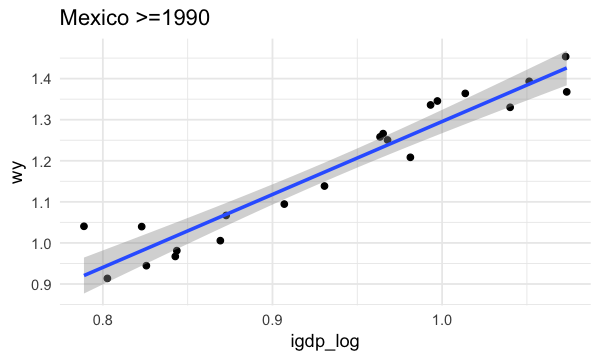

In [150]:
ggplot(test[ctry=='Mexico' & year>= 1990], aes(igdp_log, wy)) + geom_point() + geom_smooth(method='lm') + theme_minimal() + 
    labs(title='Mexico >=1990')

In [132]:
print(screenreg(lm(wy ~ igdp_log, data = test[ctry=='Mexico' & year>= 1990])))


             Model 1  
----------------------
(Intercept)  -0.48 ***
             (0.11)   
igdp_log      1.78 ***
             (0.12)   
----------------------
R^2           0.92    
Adj. R^2      0.91    
Num. obs.    21       
RMSE          0.05    
*** p < 0.001, ** p < 0.01, * p < 0.05


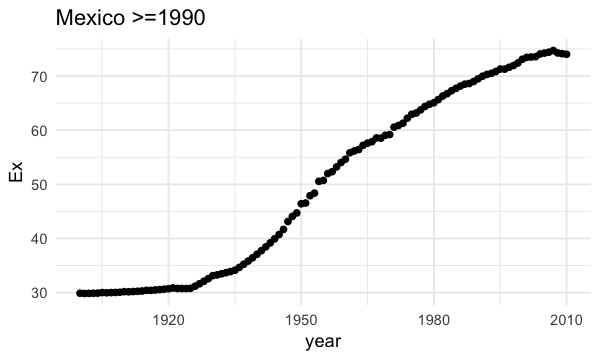

In [148]:
ggplot(test[ctry=='Mexico'], aes(year, Ex)) + geom_point()  + theme_minimal() + 
    labs(title='Mexico >=1990')

# Argentina 1950 using segment 1990

In [133]:
coeffs = t(ss[, .SD, .SDcols = names(ss) %like% '^b|Argentina'])

In [151]:
coeffs

b_Intercept,0.33976808
b_igdp_log,0.76234434
"r_ctry_year[Argentina.1950,Intercept]",-0.73344789
"r_ctry_year[Argentina.1950-1969,Intercept]",-0.08791148
"r_ctry_year[Argentina.1970-1989,Intercept]",0.70430181
"r_ctry_year[Argentina.1990,Intercept]",-0.07829758
"r_ctry_year[Argentina.1950,igdp_log]",0.48462614
"r_ctry_year[Argentina.1950-1969,igdp_log]",-0.23644627
"r_ctry_year[Argentina.1970-1989,igdp_log]",-0.94058347
"r_ctry_year[Argentina.1990,igdp_log]",0.09051524


In [143]:
test[ctry=='Argentina' & year==1990, igdp_log]

[1] 0.8582814
attr(,"scaled:center")
[1] 7.910903

In [135]:
(log_gpd_argentina_1950 = test[ctry=='Argentina' & year==1950, igdp_log])
(max_value = test[ctry=='Argentina' & year==1950, max_le])

[1] 0.6036318
attr(,"scaled:center")
[1] 7.910903

[1] 76.13545

In [136]:
(cf = coeffs[1] + coeffs[6] + log_gpd_argentina_1950 * (coeffs[2] + coeffs[10]))

[1] 0.7762837
attr(,"scaled:center")
[1] 7.910903

In [137]:
# counterfactual
(acf = get_orig_values_weibull(cf, max_value))

[1] 67.47182
attr(,"scaled:center")
[1] 7.910903

In [138]:
# observed
(obs = test[ctry=='Mexico' & year==1950, Ex])

[1] 46.40561

In [139]:
obs - acf

[1] -21.06621
attr(,"scaled:center")
[1] 7.910903

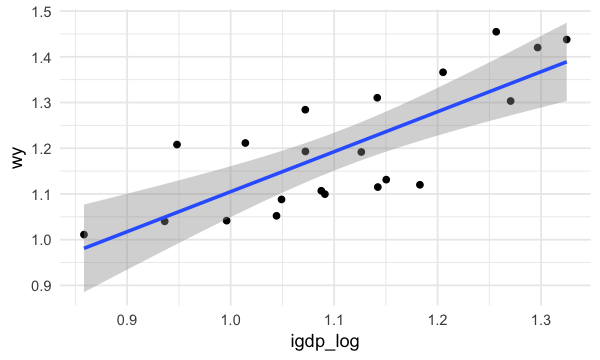

In [152]:
ggplot(test[ctry=='Argentina' & year>= 1990], aes(igdp_log, wy)) + geom_point() + geom_smooth(method='lm') + theme_minimal()

In [141]:
print(screenreg(lm(wy ~ igdp_log, data = test[ctry=='Argentina' & year>= 1990])))


             Model 1  
----------------------
(Intercept)   0.23    
             (0.18)   
igdp_log      0.87 ***
             (0.17)   
----------------------
R^2           0.60    
Adj. R^2      0.57    
Num. obs.    21       
RMSE          0.09    
*** p < 0.001, ** p < 0.01, * p < 0.05


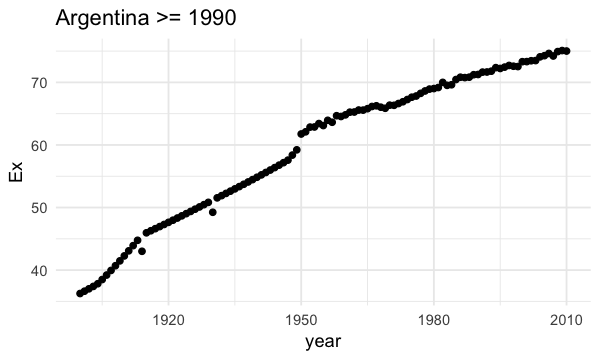

In [155]:
ggplot(test[ctry=='Argentina'], aes(year, Ex)) + geom_point()  + theme_minimal() + 
    labs(title='Argentina >= 1990')